# Prospecção de Dados (Data Mining) DI/FCUL - HA1

## First Home Assignement (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP: `02`

* João Martins, 62532 - Hours worked on the project
* Rúben Torres, 62531 - Hours worked on the project
* Nuno Pereira, 56933 - Hours worked on the project




The purpose of this Home Assignment is
* Read a Data file with a Set of Texts
* Compute similarities between texts
* Perform simple classification of texts using a Naive Bayes classifier

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**


## 1. Read the Dataset

The dataset is the file `Sentences_75Agree.txt` from the [Financial Sentiment Analysis database on Gugging Face](https://huggingface.co/datasets/financial_phrasebank)

* Read the dataset and separate them by unique documents (one document per line)
* The last word of each document is the class and it **must be removed from the document** but kept separate for use in the classification tasks below
    * classes can be `.@positive`, `.@negative`, `.@neutral`
    


In [567]:
import numpy as np
import unicodedata
from math import log2


FILE_NAME: str = "Sentences_75Agree.txt"
CLASS_DELIMITER: str = "@"


def classify_document(document: str) -> dict[str, str]:
    s: str = document.strip().split(CLASS_DELIMITER)
    return {"document": s[0], "class": s[-1]}


documents: list[str] = open(FILE_NAME, encoding="ISO-8859-15").readlines()
documents_classified: list[dict[str, str]] = [
    classify_document(document) for document in documents
]

## 2. Compute similarities between texts

* Compute the TF.IDF of all words in texts
* compute the average similarity beween texts
* Plot the document similarity distribution (suggestion use [boxplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html) or [histograms](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) or  [histograms with density](https://matplotlib.org/stable/gallery/statistics/histogram_features.html))
* Comment your results


In [568]:
# ========== CORPUS Start ========== #


def basic_word_tokenizer(text: str) -> list[str]:
    return text.split()


def remove_accents(text: str) -> str:
    nfkd_form: str = unicodedata.normalize("NFKD", text)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])


def remove_stuff(text: str) -> str:
    for c in '\\\t0123456789Ææœ—‘’\ufeff{|}“”.,()$£%&[]?@#!=;*+–"ǁ':
        text = text.replace(c, "")
    text = text.replace("-", " ")
    return text


def get_words_from_text(text: str) -> list[str]:
    text = text.strip().lower()
    text = remove_accents(text)
    text = remove_stuff(text)
    text = text.lower()
    return basic_word_tokenizer(text)


def get_words_from_corpus(corpus: list[str]) -> list[list[str]]:
    return [get_words_from_text(text) for text in corpus]


# ========== CORPUS End ========== #

# ========== TF Start ========== #


def word_counter(words: list[str]) -> dict[str, int]:
    unique_words: set[str] = set(words)
    counter: dict[str, int] = dict(zip(unique_words, [0] * len(unique_words)))
    for word in words:
        counter[word] += 1
    return counter


def TF(word_counts: dict[str, int]) -> dict[str, int]:
    counts: list[int] = list(word_counts.values())
    if len(counts) == 0:
        return {}
    counts_max: int = max(counts)
    return dict(zip(word_counts.keys(), [count / counts_max for count in counts]))


def TF_all(words_texts: list[list[str]]) -> list[dict[str, int]]:
    return [TF(word_counter(words)) for words in words_texts]


# ========== TF End ========== #

# ========== IDF Start ========== #


def IDF_all(words_texts_sets: list[set[str]]) -> dict[str, float]:
    all_words: set[str] = set.union(*words_texts_sets)
    counter: dict[str, int] = dict(zip(all_words, [0] * len(all_words)))
    total_number_of_documents: int = len(words_texts_sets)
    for words in words_texts_sets:
        for word in words:
            counter[word] += 1
    return {word: log2(total_number_of_documents / counter[word]) for word in counter}


# ========== IDF End ========== #

# ========== TF-IDF Start ========== #


def TF_IDF_cosine_similarity(
    idx1: int,
    idx2: int,
    words_texts_sets: list[set[str]],
    all_tfs: list[dict[str, int]],
    all_idfs: dict[str, float],
):
    text1: set[str] = words_texts_sets[idx1]
    text2: set[str] = words_texts_sets[idx2]
    common_words: set[str] = text1 & text2
    if len(common_words) == 0:
        return 0.0

    tfs1: dict[str, int] = all_tfs[idx1]
    tfs2: dict[str, int] = all_tfs[idx2]
    common_tfidfs: list[float] = [
        tfs1[word] * tfs2[word] * all_idfs[word] * all_idfs[word]
        for word in common_words
    ]

    tfidfs2_1 = np.array([tfs1[word] * all_idfs[word] for word in text1]) ** 2
    tfidfs2_2 = np.array([tfs2[word] * all_idfs[word] for word in text2]) ** 2

    return sum(common_tfidfs) / (np.sqrt(tfidfs2_1.sum()) * np.sqrt(tfidfs2_2.sum()))


def text_similarities(
    words_texts_sets: list[set[str]],
    all_tfs: list[dict[str, int]],
    all_idfs: dict[str, float],
) -> list[tuple[float, tuple[int, int]]]:
    total_number_of_documents: int = len(words_texts_sets)
    return [
        (TF_IDF_cosine_similarity(i, j, words_texts_sets, all_tfs, all_idfs), (i, j))
        for i in range(total_number_of_documents - 1)
        for j in range(i + 1, total_number_of_documents)
    ]


# ========== TF-IDF End ========== #

In [569]:
corpus: list[str] = [
    document_classified["document"] for document_classified in documents_classified
]

words_texts: list[list[str]] = get_words_from_corpus(corpus)
all_tfs: list[dict[str, int]] = TF_all(words_texts)

words_texts_sets: list[set[str]] = [set(words) for words in words_texts]
all_idfs: dict[str, float] = IDF_all(words_texts_sets)

similarities: list[tuple[float, tuple[int, int]]] = text_similarities(
    words_texts_sets, all_tfs, all_idfs
)
similarities = sorted(similarities, reverse=True)

results: list[float] = [min(1.0, similarity) for similarity, _ in similarities]
results

{'cranes': 8.29420300021609, 'artistic': 11.753634618853386, 'comparable': 8.431706523966024, 'repurchase': 9.753634618853386, 'human': 9.753634618853386, 'website': 8.753634618853386, 'treatment': 8.946279696795782, 'th': 9.753634618853386, 'invention': 9.431706523966024, 'lesprom': 10.753634618853386, 'authority': 9.431706523966024, 'reportable': 11.753634618853386, 'northwest': 11.753634618853386, 'iittala': 10.16867211813223, 'straight': 11.753634618853386, 'procurement': 9.431706523966024, 'rocketed': 10.753634618853386, 'adp': 7.230072662796374, 'es': 11.753634618853386, 'sub': 11.753634618853386, 'dragonfly': 11.753634618853386, 'encompassing': 11.753634618853386, 'element': 11.753634618853386, 'commissioned': 9.753634618853386, 'jot': 11.753634618853386, 'finish': 10.753634618853386, 'yards': 9.753634618853386, 'trent': 11.753634618853386, 'ruokatalo': 8.946279696795782, 'minn': 11.753634618853386, 'egypt': 11.753634618853386, 'construct': 10.753634618853386, 'master': 9.753634

### Your short analysis here

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum


## 3. Make a Naive Bayes Classifier 

* Split dataset randomly into training and testing (20% for testing)
* Train a Naive Bayes Model and do some sensitivity analyis on the hyperparameters 
* Evaluate your results with the testing set


In [570]:
### Add supporting functions here
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix, precision_score, recall_score, accuracy_score
from random import sample, shuffle
from typing import List, Tuple
import matplotlib.pyplot as plt
from scipy.stats import norm

def PD_NBa(X, y, alpha=0) -> Tuple[List, List]:
    X = np.array(X, dtype=str)
    M=X.shape   

    yv, yc=np.unique(y, return_counts=True)
    priors={yv[i]: yc[i]/sum(yc) for i in range(len(yv)) }

    L_hoods={}
    for j in range(M[0]):
        xs = tuple(np.unique(X[j]))  # Convert set to tuple
        for v in xs:
            for yi in yv: 
                L_hoods[(j, v,  yi)] = alpha

    for yi in yv:
        X_c = X[y == yi]
        # Iterate over each individual word in X_c
        for words in X_c:
            # Iterate over each character in the word
            for v in words:
                vs, cs = np.unique(words, return_counts=True)
                for i, v in enumerate(vs):
                    L_hoods[(j, v,  yi)] = cs[i]/np.sum(cs)
    
    return priors, L_hoods

def show_NB(priors, L_hoods):
    print("Priors are:")
    for yi in priors:
        print("\tP(Y = %s) = %7.4f" % (yi, priors[yi]))
    print("Likelyhoods:")
    for i, xi, yi in L_hoods:
        print("\tP(X%d = %s | Y = %s) = %7.4f" % (i, xi, yi, L_hoods[(i,xi,yi)]))

def make_train_test(X, y, r=0.2) -> Tuple[list[str], list[int], list[str], list[int]]:
    N=len(X)
    test_idx  = set(sample(range(N), int(N*r)))
    train_idx = list(set(range(N)) - test_idx)
    test_idx =list(test_idx)
    shuffle(train_idx)
    shuffle(test_idx)
    train_set_X = [X[i] for i in train_idx]
    train_set_y = [y[i] for i in train_idx]
    test_set_X = [X[i] for i in test_idx]
    test_set_y = [y[i] for i in test_idx]
    return train_set_X, train_set_y, test_set_X, test_set_y

# def make_train_test(X, y, r=0.25) -> Tuple[list[str], list[int], list[str], list[int]]:
#     N=len(X)
#     D=list(range(N))
#     shuffle(D)
#     train_set_X = [X[i] for i in D[int(N*r):]]
#     train_set_y = [y[i] for i in D[int(N*r):]]
#     test_set_X = [X[i] for i in D[:int(N*r)]]
#     test_set_y = [y[i] for i in D[:int(N*r)]]
#     return train_set_X, train_set_y, test_set_X, test_set_y

def calc_prior_counts(labels) -> list[float]:
    yv, yc=np.unique(labels, return_counts=True)
    priors=np.ones(len(yv))
    priors[yv]=yc
    return priors

def calc_all_words(words_text_sets) -> list[str]:
    all_words=set()
    for words in words_text_sets: 
        all_words |= words
    return all_words


def init_likelihood_counts(docs_words, n_labels) -> dict:
    all_words=calc_all_words(docs_words)
    L_hoods={}
    for w in all_words:
        L_hoods[w]=np.zeros(n_labels)
    return L_hoods

def update_likelihood_counts(L_hoods, words, label) -> None:
    for word in words: 
        L_hoods[word][label]+=1

def calc_likelihood_counts(docs_words, labels) -> dict:
    n_labels=len(set(labels))
    L_hoods = init_likelihood_counts(docs_words, n_labels)
    for i, words in enumerate(docs_words): 
        update_likelihood_counts(L_hoods, words, labels[i])
    return L_hoods

def classify_new_document(words, priors, L_hoods, alpha=0) -> list[float]:
    res=priors/priors.sum()
    alpha_vec=np.ones(len(res))*alpha
    for word in words:
        if word in L_hoods: 
            res*=(L_hoods[word]/L_hoods[word].sum() + alpha_vec)
    return res/res.sum()

def classify_documents(docs, priors, L_hoods, alpha=0) -> list[int]:
    return [classify_new_document(words, priors, L_hoods, alpha).argmax(axis=0) for words in docs]

def calc_posterior(data, priors, L_hoods):
    probs=np.zeros(len(priors))
    for j, yp in enumerate(priors.keys()):
        probs[j]=priors[yp]
        for i, d in enumerate(data): 
            probs[j]*=L_hoods[(i, d, yp)]
    #scaling to 1.0
    probs=probs/np.sum(probs)
    return {yp: probs[j] for j, yp in enumerate(priors.keys())}

def model_evaluation(y_test, preds) -> None:
    print("The Accuracy score is: %7.4f" % accuracy_score(y_test, preds))
    print("The F1 score is: %7.4f" % f1_score(y_test, preds, average='weighted'))
    print("The MCC score is: %7.4f" % matthews_corrcoef(y_test, preds))
    print("The precision score is: %7.4f" %  precision_score(y_test, preds, average='weighted'))
    print("The recall score is: %7.4f" %  recall_score(y_test, preds, average='weighted'))
    print(confusion_matrix(y_test, preds))

def plot_diferent_aplha_values(x_test, y_test, PC, LHC, preds, alphas) -> None:
    f1_scores= []
    matthews_corrcoefs = []
    precision_scores = []
    recall_scores = []

    for i in alphas:
        preds=classify_documents(x_test, PC, LHC, alpha=i)
        f1_scores.append(f1_score(y_test, preds, average='weighted', zero_division=1))
        matthews_corrcoefs.append(matthews_corrcoef(y_test, preds))
        precision_scores.append(precision_score(y_test, preds, average='weighted', zero_division=1))
        recall_scores.append(recall_score(y_test, preds, average='weighted', zero_division=1))

    plt.plot(alphas, f1_scores,'b-', marker = "o", label='F1')
    plt.plot(alphas, matthews_corrcoefs,'g-', marker = "o", label='mathews_corr')
    plt.plot(alphas, precision_scores,'r-', marker = "o", label='precision')
    plt.plot(alphas, recall_scores,'k-', marker = "o", label='recall')
    plt.xlabel("Alpha values")
    plt.ylabel("Scores")
    plt.legend()
    plt.grid()
    plt.show()


def plot_class_balance(data):
    classes = ['negative', 'neutral', 'positive']
    
    yv, yc=np.unique(data, return_counts=True)
    plt.bar(classes, yc, color ='blue', width = 0.6)
 
    plt.xlabel("Nº classes")
    plt.ylabel("No. of instances")
    plt.show()

The Accuracy score is:  0.7203
The F1 score is:  0.6703
The MCC score is:  0.4332
The precision score is:  0.7486
The recall score is:  0.7203
[[ 11  51  22]
 [  0 412   9]
 [  0 111  74]]


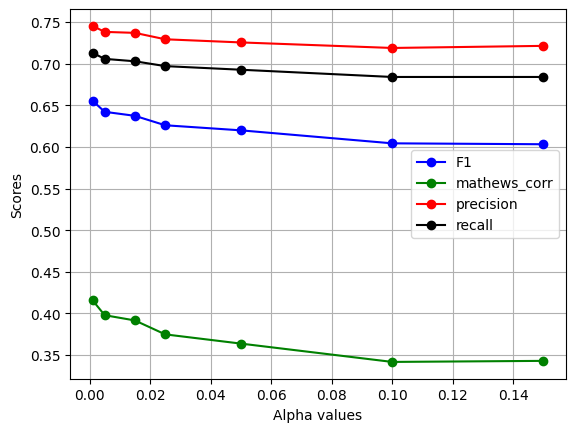

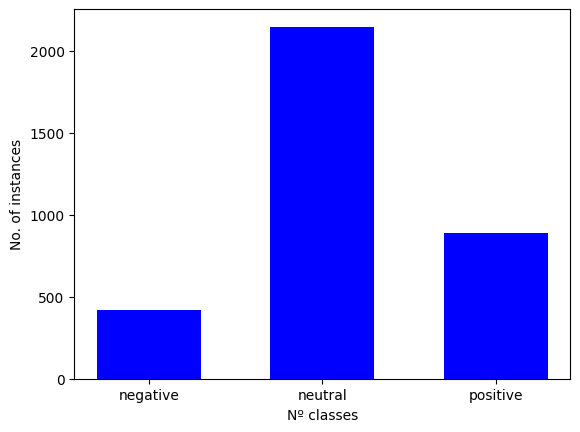

Priors are:
	P(Y = 0) =  0.1216
	P(Y = 1) =  0.6215
	P(Y = 2) =  0.2569
Likelyhoods:
	P(X0 = {'where', 'all', 'gran', 'plans', 'to', 'although', 'is', 'no', 'move', 'that', 'according', 'has', 'russia', 'growing', 'the', 'production', 'company'} | Y = 0) =  0.0800
	P(X0 = {'where', 'all', 'gran', 'plans', 'to', 'although', 'is', 'no', 'move', 'that', 'according', 'has', 'russia', 'growing', 'the', 'production', 'company'} | Y = 1) =  0.0800
	P(X0 = {'where', 'all', 'gran', 'plans', 'to', 'although', 'is', 'no', 'move', 'that', 'according', 'has', 'russia', 'growing', 'the', 'production', 'company'} | Y = 2) =  0.0800
	P(X1 = {'its', 'of', 'in', 'production', 'would', 'meet', 'with', 'the', 'company', 'new', 'materials', 'capacity', 'increase', 'to', 'plant', 'expected', 'improve', 'raw', 'therefore', 'use', 'and', 'demand', 'profitability'} | Y = 0) =  0.0800
	P(X1 = {'its', 'of', 'in', 'production', 'would', 'meet', 'with', 'the', 'company', 'new', 'materials', 'capacity', 'increase',

In [571]:
### Add processing code here
class_encoding = {'negative': 0, 'neutral': 1, 'positive': 2}

y_corpus: list[str] = [class_encoding[documents_classified["class"]] for documents_classified in documents_classified]
x_corpus = words_texts_sets

x_train, y_train, x_test, y_test = make_train_test(x_corpus, y_corpus, r=0.2)


PC: list[float] = calc_prior_counts(y_train)
LHC: list[float] = calc_likelihood_counts(x_train, y_train)

preds: list[int]=classify_documents(x_test, PC, LHC, alpha=0.0001)

# for i, words in enumerate(x_test[:10]):
#     print(i, "--", preds[i], "<--", words)

model_evaluation(y_test, preds)


alphas = [0.001, 0.005, 0.015, 0.025, 0.05, 0.1, 0.15]
plot_diferent_aplha_values(x_test, y_test, PC, LHC, preds, alphas)
plot_class_balance(y_corpus)

# print(words_texts_sets)

priors, L_hoods = PD_NBa(words_texts_sets, y_corpus, 0.08)

show_NB(priors, L_hoods)


## 4. Discuss your findings [to fill on your own]

* Comment your results above
* Discuss how could they be used in a Big Data environment


Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum
